## Experiment

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pennylane as qml
import random
import time

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# QViT Model Classes (with fix for device handling)
class TorchLayer(nn.Module):
    def __init__(self, qnode, weights):
        if not torch.cuda.is_available():
            raise ImportError("TorchLayer requires PyTorch with CUDA support.")
        super().__init__()
        self.qnode = qnode
        self.qnode.interface = "torch"
        self.qnode_weights = {k: v.to(device) for k, v in weights.items()}  # Move weights to device

    def forward(self, inputs):
        if len(inputs.shape) > 1:
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)
        return self._evaluate_qnode(inputs)

    def _evaluate_qnode(self, x):
        kwargs = {
            self.input_arg: x,
            **{arg: weight.to(x.device) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)
        if isinstance(res, torch.Tensor):
            return res.type(x.dtype).to(x.device)
        return torch.hstack(res).type(x.dtype).to(x.device)

    def __str__(self):
        return f"<Quantum Torch Layer: func={self.qnode.func.__name__}>"

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        return self._input_arg

class QSAL_pennylane(nn.Module):
    def __init__(self, S, n, Denc, D):
        super().__init__()
        self.seq_num = S  # Number of sequence positions
        self.num_q = n    # Number of qubits
        self.Denc = Denc  # Depth of encoding ansatz
        self.D = D        # Depth of Q, K, V ansatzes
        self.d = n * (Denc + 2)  # Dimension of input/output vectors
        self.dev = qml.device("lightning.gpu", wires=self.num_q)

        # Define observables for value circuit (cycle through Z, X, Y per qubit)
        self.observables = []
        for i in range(self.d):
            qubit = i % self.num_q
            pauli_idx = (i // self.num_q) % 3
            if pauli_idx == 0:
                obs = qml.PauliZ(qubit)
            elif pauli_idx == 1:
                obs = qml.PauliX(qubit)
            else:
                obs = qml.PauliY(qubit)
            self.observables.append(obs)

        # Initialize single set of parameters for Q, K, V
        self.init_params_Q = nn.Parameter((np.pi / 4) * (2 * torch.randn(n * (D + 2)) - 1).to(device))
        self.init_params_K = nn.Parameter((np.pi / 4) * (2 * torch.randn(n * (D + 2)) - 1).to(device))
        self.init_params_V = nn.Parameter((np.pi / 4) * (2 * torch.randn(n * (D + 2)) - 1).to(device))

        # Weight dictionaries for TorchLayer
        self.weight_q = {"weights": self.init_params_Q}
        self.weight_k = {"weights": self.init_params_K}
        self.weight_v = {"weights": self.init_params_V}

        # Define quantum nodes
        self.vqnod = qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod = qml.QNode(self.circuit_qk, self.dev, interface="torch")

        # Single TorchLayer instances for Q, K, V
        self.q_linear = TorchLayer(self.qnod, self.weight_q)
        self.k_linear = TorchLayer(self.qnod, self.weight_k)
        self.v_linear = TorchLayer(self.vqnod, self.weight_v)

    def circuit_v(self, inputs, weights):
        """Value circuit returning a d-dimensional vector of different observable expectations."""
        idx = 0
        # Encoding ansatz U_enc
        for j in range(self.num_q):
            qml.RX(inputs[idx], wires=j)
            qml.RY(inputs[idx + 1], wires=j)
            idx += 2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j, (j + 1) % self.num_q))
            for j in range(self.num_q):
                qml.RY(inputs[idx], wires=j)
                idx += 1
        # Value ansatz U_v
        idx = 0
        for j in range(self.num_q):
            qml.RX(weights[idx], wires=j)
            qml.RY(weights[idx + 1], wires=j)
            idx += 2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j, (j + 1) % self.num_q))
            for j in range(self.num_q):
                qml.RY(weights[idx], wires=j)
                idx += 1
        return [qml.expval(obs) for obs in self.observables]

    def circuit_qk(self, inputs, weights):
        """Query/Key circuit returning Pauli-Z expectation on qubit 0."""
        idx = 0
        # Encoding ansatz U_enc
        for j in range(self.num_q):
            qml.RX(inputs[idx], wires=j)
            qml.RY(inputs[idx + 1], wires=j)
            idx += 2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j, (j + 1) % self.num_q))
            for j in range(self.num_q):
                qml.RY(inputs[idx], wires=j)
                idx += 1
        # Query/Key ansatz U_q or U_k
        idx = 0
        for j in range(self.num_q):
            qml.RX(weights[idx], wires=j)
            qml.RY(weights[idx + 1], wires=j)
            idx += 2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j, (j + 1) % self.num_q))
            for j in range(self.num_q):
                qml.RY(weights[idx], wires=j)
                idx += 1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self, input):
        """Vectorized forward pass with shared parameters."""
        batch_size = input.size(0)
        S = self.seq_num
        d = self.d

        # Reshape input to (S * batch_size, d) for batch processing
        input_flat = input.transpose(0, 1).reshape(S * batch_size, d)

        # Compute Q, K, V in single calls
        Q_output_flat = self.q_linear(input_flat)  # Shape: (S * batch_size, 1)
        K_output_flat = self.k_linear(input_flat)  # Shape: (S * batch_size, 1)
        V_output_flat = self.v_linear(input_flat)  # Shape: (S * batch_size, d)

        # Reshape back to include sequence dimension
        Q_output = Q_output_flat.reshape(S, batch_size, 1).transpose(0, 1)  # (batch_size, S, 1)
        K_output = K_output_flat.reshape(S, batch_size, 1).transpose(0, 1)  # (batch_size, S, 1)
        V_output = V_output_flat.reshape(S, batch_size, d).transpose(0, 1)  # (batch_size, S, d)

        # Compute Gaussian self-attention coefficients
        Q_expanded = Q_output.unsqueeze(2)  # (batch_size, S, 1, 1)
        K_expanded = K_output.unsqueeze(1)  # (batch_size, 1, S, 1)
        alpha = torch.exp(-(Q_expanded - K_expanded) ** 2)  # (batch_size, S, S, 1)

        # Normalize attention coefficients
        Sum_a = torch.sum(alpha, dim=2, keepdim=True)  # (batch_size, S, 1, 1)
        alpha_normalized = alpha / Sum_a  # (batch_size, S, S, 1)

        # Compute weighted sum of values
        V_output_expanded = V_output.unsqueeze(1)  # (batch_size, 1, S, d)
        weighted_V = alpha_normalized * V_output_expanded  # (batch_size, S, S, d)
        Sum_w = torch.sum(weighted_V, dim=2)  # (batch_size, S, d)

        # Add residual connection
        output = input + Sum_w
        return output

class QSANN_pennylane(nn.Module):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__()
        self.qsal_lst = [QSAL_pennylane(S, n, Denc, D) for _ in range(num_layers)]
        self.qnn = nn.Sequential(*self.qsal_lst)

    def forward(self, input):
        return self.qnn(input)

class QSANN_text_classifier(nn.Module):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__()
        self.Qnn = QSANN_pennylane(S, n, Denc, D, num_layers)
        self.final_layer = nn.Linear(n * (Denc + 2) * S, 1).float()

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        return torch.sigmoid(self.final_layer(x))



Using device: cuda


In [8]:
# Training and Evaluation Code
def load_digits_data(n_train, n_test):
    """
    Load and preprocess digits dataset for digits 0 and 1.
    """
    digits = load_digits()
    X, y = digits.data, digits.target
    mask = (y == 0) | (y == 1)  # Filter for digits 0 and 1
    X, y = X[mask], y[mask]
    X = X / np.linalg.norm(X, axis=1,keepdims=True)
    X = X.reshape(-1,4,16)
    y = y.astype(np.float32)  # Labels are already 0 and 1
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_train, test_size=n_test)
    # Convert to tensors and move to device
    return (
        torch.tensor(X_train, dtype=torch.float32).to(device),
        torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device),
        torch.tensor(X_test, dtype=torch.float32).to(device),
        torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
    )

def train_qvit(n_train, n_test, n_epochs):
    """
    Train the QViT model and track metrics, ensuring all tensors are on the same device.
    """
    # Load data (already moved to device)
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test)

    # Initialize QViT model and move it to the device
    model = QSANN_text_classifier(S=4, n=4, Denc=2, D=1, num_layers=1).to(device)

    # Define loss and optimizer
    criterion = nn.BCELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.01)

    # Data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for epoch in range(n_epochs):
        start=time.time()
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Record training metrics
        train_cost = loss.item()
        train_acc = ((outputs > 0.5).float() == y_train).float().mean().item()
        train_cost_epochs.append(train_cost)
        train_acc_epochs.append(train_acc)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_acc = ((test_outputs > 0.5).float() == y_test).float().mean().item()
        test_cost_epochs.append(test_loss)
        test_acc_epochs.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 1 == 0:
            print(f"Train Size: {n_train}, Epoch: {epoch + 1}/{n_epochs}, "
                  f"Train Loss: {train_cost:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        print(f'Epoch time: {time.time()-start:.6f} seconds')

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

# Constants
n_test = 100
n_epochs = 100
n_reps = 1
train_sizes = [40]

def run_iterations(n_train):
    """
    Run multiple training iterations for a given training size and print progress.
    """
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )
    for rep in range(n_reps):
        print(f"\nStarting repetition {rep + 1}/{n_reps} for train size {n_train}")
        results = train_qvit(n_train, n_test, n_epochs)
        results_df = pd.concat([results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True)
    return results_df

In [9]:
import pandas as pd
from filelock import FileLock

output_file = "results.csv"
lock_file = output_file + ".lock"

# Create an empty file with header once (only if it doesn't exist)
try:
    with open(output_file, 'x') as f:
        pd.DataFrame(columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]).to_csv(f, index=False)
except FileExistsError:
    pass  # File already exists

for n_train in train_sizes:
    print(f"\n=== Starting training for train size {n_train} ===")
    results_df = run_iterations(n_train)

    # Append safely to CSV with file locking
    with FileLock(lock_file):
        results_df.to_csv(output_file, mode='a', index=False, header=False)



=== Starting training for train size 40 ===

Starting repetition 1/1 for train size 40
Train Size: 40, Epoch: 1/100, Train Loss: 0.6978, Train Acc: 0.3250, Test Loss: 0.6978, Test Acc: 0.4500
Epoch time: 16.272390 seconds
Train Size: 40, Epoch: 2/100, Train Loss: 0.6845, Train Acc: 0.5750, Test Loss: 0.6905, Test Acc: 0.4400
Epoch time: 15.976303 seconds
Train Size: 40, Epoch: 3/100, Train Loss: 0.6718, Train Acc: 0.5750, Test Loss: 0.6834, Test Acc: 0.4400
Epoch time: 16.370455 seconds
Train Size: 40, Epoch: 4/100, Train Loss: 0.6596, Train Acc: 0.5750, Test Loss: 0.6763, Test Acc: 0.4400
Epoch time: 16.434750 seconds


KeyboardInterrupt: 

In [10]:
results_df=pd.read_csv('results.csv')
results_df

,train_acc,train_cost,test_acc,test_cost,step,n_train
0,0.5,0.683929,0.50,0.687919,1,2
1,0.5,0.666832,0.50,0.679183,2,2
2,0.5,0.650045,0.54,0.670550,3,2
3,0.5,0.633551,0.60,0.661973,4,2
4,1.0,0.617325,0.66,0.653418,5,2
...,...,...,...,...,...,...
19995,1.0,0.073073,0.73,0.467631,96,5
19996,1.0,0.071656,0.73,0.466038,97,5
19997,1.0,0.070281,0.75,0.464187,98,5
19998,1.0,0.068946,0.75,0.462174,99,5


In [11]:
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()
df_agg

n_train step train_acc           train_cost           test_acc            \
                      mean       std       mean       std     mean       std   
0         2    1     0.500  0.408248   0.692714  0.065200   0.5362  0.146988   
1         2    2     0.710  0.377258   0.649725  0.063079   0.5661  0.144151   
2         2    3     0.900  0.213201   0.609386  0.068988   0.5842  0.156070   
3         2    4     0.950  0.150756   0.571445  0.079454   0.6027  0.175193   
4         2    5     0.965  0.128216   0.535732  0.091637   0.6166  0.186121   
..      ...  ...       ...       ...        ...       ...      ...       ...   
195       5   96     1.000  0.000000   0.085108  0.038434   0.8922  0.139121   
196       5   97     1.000  0.000000   0.083590  0.037869   0.8925  0.138742   
197       5   98     1.000  0.000000   0.082111  0.037315   0.8929  0.138581   
198       5   99     1.000  0.000000   0.080671  0.036773   0.8931  0.138584   
199       5  100     1.000  0.000000   0.079267  0.036241   0.8934  0.138515   

    test_cost            
         mean       std  
0    0.690883  0.014668  
1    0.689090  0.019770  
2    0.689600  0.027954  
3    0.692407  0.038660  
4    0.697524  0.051681  
..        ...       ...  
195  0.463368  0.747231  
196  0.462777  0.750102  
197  0.462220  0.752936  
198  0.461692  0.755727  
199  0.461189  0.758475  

[200 rows x 10 columns]

In [12]:
train_sizes=[2,5]

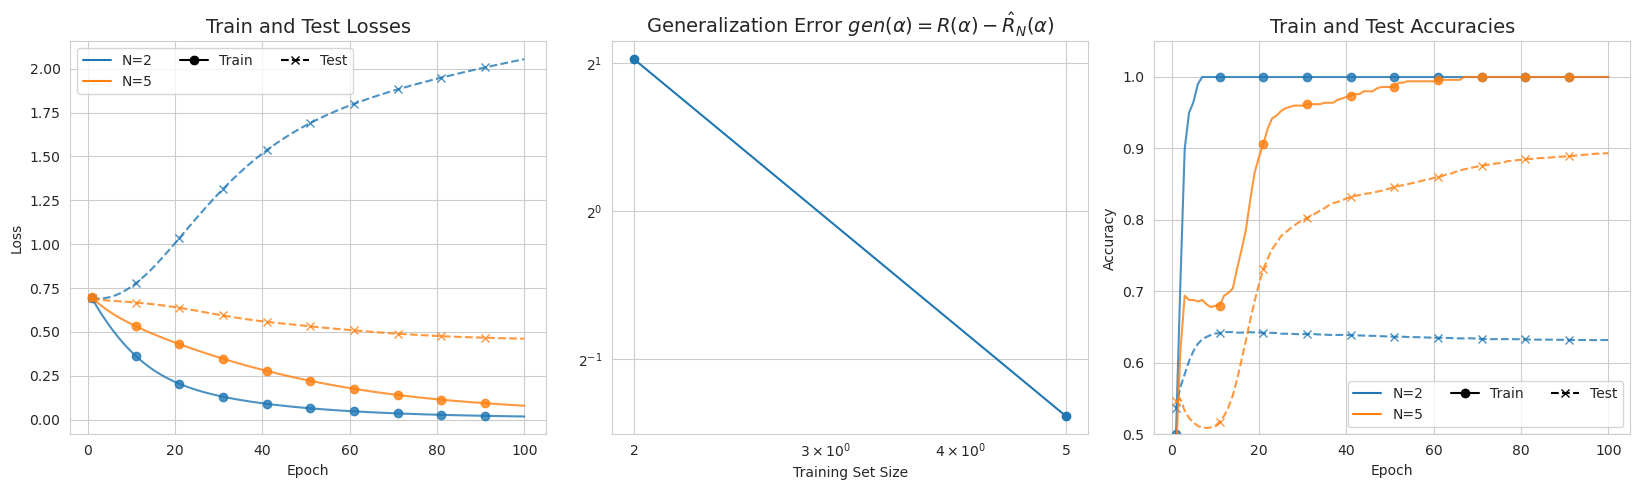

In [13]:
# Aggregate results
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()

# Plotting
sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5))

generalization_errors = []

# Plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]
    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0, 0, 2, 2]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)

    # Compute generalization error
    dif = df[df.step == 100].test_cost["mean"].values[0] - df[df.step == 100].train_cost["mean"].values[0]
    generalization_errors.append(dif)

# Format plots
axes[0].set_title('Train and Test Losses', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
axes[1].set_xscale('log')
axes[1].set_xticks(train_sizes)
axes[1].set_xticklabels(train_sizes)
axes[1].set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
axes[1].set_xlabel('Training Set Size')
axes[1].set_yscale('log', base=2)

axes[2].set_title('Train and Test Accuracies', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_ylim(0.5, 1.05)

legend_elements = (
    [mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)] +
    [
        mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
        mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]
)

axes[0].legend(handles=legend_elements, ncol=3)
axes[2].legend(handles=legend_elements, ncol=3)

plt.tight_layout()
plt.show()